In [25]:
import torch
import torchvision
import numpy as np
from copy import deepcopy
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt


In [26]:
### Hyperparameters
val_split = 0.1
unlabelled_size = 0.99
lr = 0.0005
batch_size = 64
num_epochs = 100
label_iterations = 100
torch.manual_seed(42)

In [27]:
## CIFAR-10
# Define transformations
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Download datasets
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [28]:
val_dataset = deepcopy(train_dataset)

In [29]:
train_size = int((1 - val_split) * len(train_dataset))
val_size = len(train_dataset) - train_size
indexes = torch.randperm(len(train_dataset)).tolist()
# Define validation set
indexes_val = indexes[train_size:]
val_dataset.targets =torch.as_tensor(val_dataset.targets)[indexes_val].cpu().numpy()
val_dataset.data = torch.as_tensor(val_dataset.data)[indexes_val].cpu().numpy()
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)

In [30]:
# Define training set
indexes_train = indexes[:train_size]
train_dataset.targets = torch.as_tensor(train_dataset.targets)[indexes_train].cpu().numpy()
train_dataset.data = torch.as_tensor(train_dataset.data)[indexes_train].cpu().numpy()

In [31]:
# Split training data into labelled and unlabelled
unused_size_n = int(unlabelled_size * len(train_dataset))

indexes_train = torch.randperm(len(train_dataset)).tolist()  # Redefine indexes_train
unlabbelled_dataset = deepcopy(train_dataset)

unlabbelled_dataset.targets = torch.as_tensor(unlabbelled_dataset.targets)[indexes_train[:unused_size_n]].cpu().numpy()
unlabbelled_dataset.data = torch.as_tensor(unlabbelled_dataset.data)[indexes_train[:unused_size_n]].cpu().numpy()

train_dataset.targets = torch.as_tensor(train_dataset.targets)[indexes_train[unused_size_n:]].cpu().numpy()
train_dataset.data = torch.as_tensor(train_dataset.data)[indexes_train[unused_size_n:]].cpu().numpy()

unlabbelled_dataset.targets = unlabbelled_dataset.targets
unlabbelled_dataset.data = unlabbelled_dataset.data

start_train_dataset = deepcopy(train_dataset)  # Save for baseline
start_unlabbelled_dataset = deepcopy(unlabbelled_dataset)  # Save for baseline

In [32]:
def transfer_unlabelled_to_labeled(unused_dataset, train_dataset, indexes):
    # Convert indexes to boolean mask
    indexes = torch.tensor([i in indexes for i in range(len(unused_dataset.targets))])
    try:
        train_dataset.targets = torch.cat([train_dataset.targets, unused_dataset.targets[indexes]])
    except:
        train_dataset.targets = torch.cat([torch.as_tensor(train_dataset.targets), torch.as_tensor(unused_dataset.targets)[indexes]]).cpu().numpy()
    
    try:
        train_dataset.data = torch.cat([train_dataset.data, unused_dataset.data[indexes]])
    except:
        train_dataset.data = torch.cat([torch.as_tensor(train_dataset.data), torch.as_tensor(unused_dataset.data)[indexes]]).cpu().numpy()
    unused_dataset.targets = unused_dataset.targets[~indexes]
    unused_dataset.data = unused_dataset.data[~indexes]

    return train_dataset, unused_dataset

In [33]:
def validate_model(model, val_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [34]:
# Setup model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 10)
# Modify input layer to accept 1 channel
#model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model_parameters = deepcopy(model.state_dict())
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

c:\Users\soere\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\soere\anaconda3\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [35]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, val_interval=1):
    accuracies = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            try:
                loss = criterion(outputs, labels)
            except:
                labels = labels.long()
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % val_interval == 0:
            val_accuracy = validate_model(model, val_loader, device)
            accuracies.append(val_accuracy)
            print(f'Epoch {epoch + 1}, Accuracy: {val_accuracy:.2f}%')
    return accuracies

In [36]:
frac = 0.01

def label_iteration_uncertanty_sampling(model, train_dataset, unlabelled_dataset, device, top_frac=frac):
    # Use model to label all images in validation set
    model.eval()
    predictions = []
    unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    with torch.no_grad():
        for images, _ in tqdm(unlabelled_loader):
            images = images.to(device)
            outputs = model(images).softmax(dim=1)
            predictions.extend(outputs.detach().cpu().numpy())

    predictions = torch.tensor(predictions)
    # Find top % of images with lowest top-confidence
    top_percent = int(top_frac * len(predictions))
    _, top_indices = predictions.max(-1)[0].topk(top_percent, largest=False)
    print(f"Adding {len(top_indices)} images to training set")
    train_dataset, unlabelled_dataset = transfer_unlabelled_to_labeled(unlabelled_dataset, train_dataset, top_indices)
    
    return train_dataset, unlabelled_dataset

def label_iteration_margin_based(model, train_dataset, unlabelled_dataset, device, top_frac=frac):
    # Set the model to evaluation mode
    model.eval()
    predictions = []
    unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    with torch.no_grad():
        for images, _ in tqdm(unlabelled_loader):
            images = images.to(device)
            # Get the class probabilities using softmax
            outputs = model(images).softmax(dim=1)
            predictions.extend(outputs.cpu().numpy())

    # Convert predictions to a tensor for easier manipulation
    predictions = torch.tensor(predictions)

    # Compute the margin: difference between the top two probabilities for each data point
    sorted_probs, _ = predictions.sort(dim=1, descending=True)
    margins = sorted_probs[:, 0] - sorted_probs[:, 1]  # Top class probability minus second highest

    # Select the indices of the samples with the smallest margins
    top_percent = int(top_frac * len(margins))
    _, top_indices = margins.topk(top_percent, largest=False)  # Smallest margins, hence least confident

    print(f"Adding {len(top_indices)} images to training set")

    # Transfer the selected samples from unlabelled to labelled dataset
    train_dataset, unlabelled_dataset = transfer_unlabelled_to_labeled(unlabelled_dataset, train_dataset, top_indices)

    return train_dataset, unlabelled_dataset

In [ ]:
## Run active learning Uncertanty
datapoint_list_US = []
accuracy_list_US = []

train_dataset.targets = start_train_dataset.targets
train_dataset.data = start_train_dataset.data
unlabbelled_dataset.targets = start_unlabbelled_dataset.targets
unlabbelled_dataset.data = start_unlabbelled_dataset.data
for i in range(label_iterations):
    print(i)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    model.load_state_dict(model_parameters)  # Important to reset the model each time
    accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)
    datapoint_list_US.append(len(train_dataset))
    accuracy_list_US.append(accuracies)
    if i < label_iterations - 1:
        train_dataset, unlabbelled_dataset = label_iteration_uncertanty_sampling(model, train_dataset, unlabbelled_dataset, device, top_frac=0.001)

0


  0%|          | 0/100 [00:00<?, ?it/s]

 11%|█         | 11/100 [00:03<00:38,  2.32it/s]

Epoch 10, Accuracy: 32.14%


 21%|██        | 21/100 [00:06<00:33,  2.35it/s]

Epoch 20, Accuracy: 32.54%


 31%|███       | 31/100 [00:09<00:29,  2.31it/s]

Epoch 30, Accuracy: 32.46%


 41%|████      | 41/100 [00:12<00:26,  2.26it/s]

Epoch 40, Accuracy: 32.64%


 51%|█████     | 51/100 [00:15<00:21,  2.30it/s]

Epoch 50, Accuracy: 32.66%


 61%|██████    | 61/100 [00:17<00:16,  2.38it/s]

Epoch 60, Accuracy: 32.92%


 71%|███████   | 71/100 [00:20<00:12,  2.28it/s]

Epoch 70, Accuracy: 32.86%


 81%|████████  | 81/100 [00:23<00:08,  2.32it/s]

Epoch 80, Accuracy: 33.10%


 91%|█████████ | 91/100 [00:26<00:03,  2.28it/s]

Epoch 90, Accuracy: 33.02%


100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


Epoch 100, Accuracy: 32.74%


100%|██████████| 697/697 [00:14<00:00, 46.99it/s]


Adding 44 images to training set
1


 10%|█         | 10/100 [00:03<00:56,  1.60it/s]

Epoch 10, Accuracy: 31.86%


 20%|██        | 20/100 [00:07<00:51,  1.56it/s]

Epoch 20, Accuracy: 34.30%


 30%|███       | 30/100 [00:11<00:44,  1.59it/s]

Epoch 30, Accuracy: 33.60%


 41%|████      | 41/100 [00:16<00:31,  1.89it/s]

Epoch 40, Accuracy: 33.04%


 51%|█████     | 51/100 [00:20<00:26,  1.86it/s]

Epoch 50, Accuracy: 35.46%


 61%|██████    | 61/100 [00:24<00:21,  1.82it/s]

Epoch 60, Accuracy: 34.88%


 71%|███████   | 71/100 [00:28<00:15,  1.85it/s]

Epoch 70, Accuracy: 35.12%


 80%|████████  | 80/100 [00:31<00:13,  1.49it/s]

Epoch 80, Accuracy: 35.30%


 90%|█████████ | 90/100 [00:35<00:06,  1.51it/s]

Epoch 90, Accuracy: 35.06%


100%|██████████| 100/100 [00:38<00:00,  2.59it/s]


Epoch 100, Accuracy: 35.16%


  4%|▍         | 28/696 [00:00<00:20, 33.37it/s]

In [ ]:
## Run active learning Margin
datapoint_list_MAR = []
accuracy_list_MAR = []

train_dataset.targets = start_train_dataset.targets
train_dataset.data = start_train_dataset.data
unlabbelled_dataset.targets = start_unlabbelled_dataset.targets
unlabbelled_dataset.data = start_unlabbelled_dataset.data
for i in range(label_iterations):
    print(i)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    model.load_state_dict(model_parameters)  # Important to reset the model each time
    accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)
    datapoint_list_MAR.append(len(train_dataset))
    accuracy_list_MAR.append(accuracies)
    if i < label_iterations - 1:
        train_dataset, unlabbelled_dataset = label_iteration_margin_based(model, train_dataset, unlabbelled_dataset, device, top_frac=0.001)

0


 11%|█         | 11/100 [00:02<00:36,  2.46it/s]

Epoch 10, Accuracy: 29.96%


 21%|██        | 21/100 [00:05<00:32,  2.44it/s]

Epoch 20, Accuracy: 30.64%


 31%|███       | 31/100 [00:08<00:28,  2.41it/s]

Epoch 30, Accuracy: 31.24%


 41%|████      | 41/100 [00:11<00:24,  2.45it/s]

Epoch 40, Accuracy: 33.22%


 51%|█████     | 51/100 [00:13<00:19,  2.45it/s]

Epoch 50, Accuracy: 33.62%


 61%|██████    | 61/100 [00:16<00:15,  2.45it/s]

Epoch 60, Accuracy: 33.82%


 71%|███████   | 71/100 [00:19<00:11,  2.46it/s]

Epoch 70, Accuracy: 33.64%


 81%|████████  | 81/100 [00:22<00:08,  2.35it/s]

Epoch 80, Accuracy: 33.82%


 91%|█████████ | 91/100 [00:25<00:03,  2.45it/s]

Epoch 90, Accuracy: 33.82%


100%|██████████| 100/100 [00:27<00:00,  3.62it/s]


Epoch 100, Accuracy: 33.86%


100%|██████████| 697/697 [00:13<00:00, 51.43it/s]


Adding 44 images to training set
1


 11%|█         | 11/100 [00:03<00:35,  2.48it/s]

Epoch 10, Accuracy: 31.02%


 21%|██        | 21/100 [00:05<00:32,  2.45it/s]

Epoch 20, Accuracy: 32.86%


 31%|███       | 31/100 [00:08<00:27,  2.47it/s]

Epoch 30, Accuracy: 31.58%


 41%|████      | 41/100 [00:11<00:23,  2.46it/s]

Epoch 40, Accuracy: 30.50%


 51%|█████     | 51/100 [00:13<00:19,  2.47it/s]

Epoch 50, Accuracy: 33.00%


 61%|██████    | 61/100 [00:16<00:15,  2.47it/s]

Epoch 60, Accuracy: 33.02%


 71%|███████   | 71/100 [00:19<00:11,  2.47it/s]

Epoch 70, Accuracy: 33.12%


 81%|████████  | 81/100 [00:22<00:07,  2.47it/s]

Epoch 80, Accuracy: 33.16%


 91%|█████████ | 91/100 [00:24<00:03,  2.47it/s]

Epoch 90, Accuracy: 33.40%


100%|██████████| 100/100 [00:27<00:00,  3.65it/s]

Epoch 100, Accuracy: 33.24%


In [ ]:
# Add baseline accuracy (no active learning)
n_datapoints = len(train_dataset) - len(start_train_dataset)
model.load_state_dict(model_parameters)
# We reuse the initial training set to reduce run to run variance


try:
    train_dataset.targets = torch.cat([start_train_dataset.targets, start_unlabbelled_dataset.targets[indexes]])
except:
    train_dataset.targets = torch.cat([torch.as_tensor(start_train_dataset.targets), torch.as_tensor(start_unlabbelled_dataset.targets)[:n_datapoints]]).cpu().numpy()
    
try:
    train_dataset.data = torch.cat([start_train_dataset.data, start_unlabbelled_dataset.data[indexes]])
except:
    train_dataset.data = torch.cat([torch.as_tensor(start_train_dataset.data), torch.as_tensor(start_unlabbelled_dataset.data)[:n_datapoints]]).cpu().numpy()

In [ ]:
# Train model
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)
baseline_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)

 11%|█         | 11/100 [00:03<00:37,  2.36it/s]

Epoch 10, Accuracy: 32.86%


 21%|██        | 21/100 [00:06<00:32,  2.41it/s]

Epoch 20, Accuracy: 34.86%


 31%|███       | 31/100 [00:08<00:29,  2.34it/s]

Epoch 30, Accuracy: 35.32%


 41%|████      | 41/100 [00:11<00:25,  2.33it/s]

Epoch 40, Accuracy: 35.24%


 51%|█████     | 51/100 [00:14<00:20,  2.34it/s]

Epoch 50, Accuracy: 35.60%


 61%|██████    | 61/100 [00:17<00:16,  2.41it/s]

Epoch 60, Accuracy: 35.64%


 71%|███████   | 71/100 [00:20<00:11,  2.42it/s]

Epoch 70, Accuracy: 35.96%


 81%|████████  | 81/100 [00:23<00:07,  2.41it/s]

Epoch 80, Accuracy: 36.02%


 91%|█████████ | 91/100 [00:25<00:03,  2.47it/s]

Epoch 90, Accuracy: 35.60%


100%|██████████| 100/100 [00:28<00:00,  3.50it/s]

Epoch 100, Accuracy: 36.14%


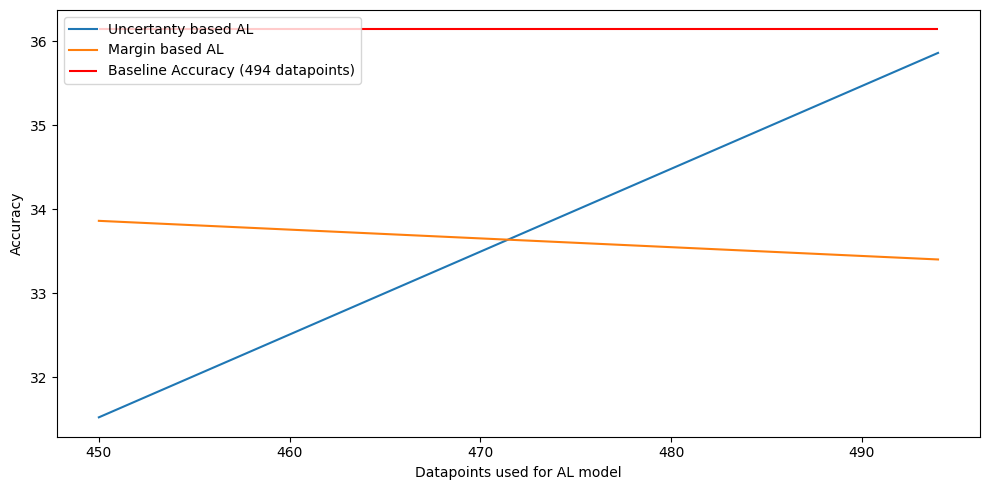

In [ ]:
# Plot the accuracy
datapoints_US = np.array(datapoint_list_US)
accuracies_US = np.array(accuracy_list_US).max(-1)
plt.figure(figsize=(10, 5))
plt.plot(datapoints_US, accuracies_US, label='Uncertanty based AL')

datapoints_MAR = np.array(datapoint_list_MAR)
accuracies_MAR = np.array(accuracy_list_MAR).max(-1)
plt.plot(datapoints_MAR, accuracies_MAR, label='Margin based AL')

plt.hlines(max(baseline_accuracy), min(datapoints_US), max(datapoints_US), label=f'Baseline Accuracy ({len(train_dataset)} datapoints)', color='red')
plt.xlabel('Datapoints used for AL model')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('figs/2_Comparison_2_CIFAR.png')
plt.show()